<a href="https://colab.research.google.com/github/hayatrajani/reinforcement-learning/blob/main/Windy_Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
from tqdm import tqdm

%matplotlib inline
np.set_printoptions(linewidth=np.inf)

# Design the Grid World

![windy_gridworld](https://drive.google.com/uc?id=10CcBBLWgMateeYRp3JFwTI--T1UgS8TQ)

The agent starts in the cell marked $S$.

When it reaches the cell marked $G$, it will receive a reward of $100$ and the episode ends.

Every other step will be rewarded with $-1$.

However, there is a crosswind running upward through the middle of the grid causing the resultant next states to shift upward by a "wind", the strength of which varies from column to column. The strength of the wind is given below each column, in number of cells shifted upward.

The agent has eight (non-deterministic) actions:

* It can move to an adjacent cell according to eight-neighborhood.
* With probability 0.8, the desired action is carried out. With probability 0.1, the agent deviates from the desired direction by one cell to the left or to the right (axis-parallel moves become diagonal moves and vice versa).
* Actions that would move the agent off the grid are handled by truncating the resulting cell coordinates to valid grid coordinates. Hence, almost all diagonal moves outside the grid (except for moves into cells extending corners) will result in a horizontal or vertical move.

In [ ]:
gridSize = (7,10)

startCell = (3,0)
goalCell = (3,7)

goalReward = 100
rewards = np.zeros(gridSize)-1
rewards[goalCell] = goalReward

winds = (0,0,0,-1,-1,-1,-2,-2,-1,0)
winds_ = np.empty(gridSize, dtype=int)
for cell in np.ndindex(gridSize):
    winds_[cell] = winds[cell[1]]+np.random.choice((-1,0,1))
getWind = lambda state, stochastic: (winds_[state],0) if stochastic else (winds[state[1]],0)

# possible actions: NW, N, NE, E, SE, S, SW, W
actions = ((-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1))
nActions = len(actions)

initPolicy = lambda: np.random.choice(range(nActions))


def step(state, actionID, deterministic=True, stochasticWind=False):
    action = actions[actionID]
    # desired action is performed with probability 0.8
    # else action deviates to the left or right
    if not deterministic:
        rand = np.random.random()
        if rand > 0.8:
            # action deviates left
            if rand > 0.9:
                thetaDev = -np.pi/4
            # action deviates right
            else:
                thetaDev = np.pi/4
            rotMat = np.array([[np.cos(thetaDev),-np.sin(thetaDev)],
                            [np.sin(thetaDev),np.cos(thetaDev)]])
            # deviated action
            action = np.round(rotMat @ action).astype(int)
    # check wind strength (blowing upwards and sometimes varying by 1)
    wind = getWind(state, stochasticWind)
    # determine the new state and reward
    state = tuple(s+a+w for s,a,w in zip(state,action,wind))
    # truncate state to valid cell coordinates if agent moves off grid
    state = tuple(np.clip(state,0,(gridSize[0]-1,gridSize[1]-1)))
    # end episode if terminal state
    done = rewards[state] == goalReward
    return (state, rewards[state], done)


# Online Tabular TD-lambda
def policyEvaluation(policy, V=np.zeros(gridSize),
                     lmbda=0.1, gamma=0.9, alpha=0.2, decay=True,
                     episodes=1000, deterministic=True, stochasticWind=False):
    eligibility = np.zeros(gridSize)
    if decay:
        nVisit = np.zeros(gridSize, dtype=int)
    # repeat for each episode
    for episode in tqdm(range(episodes)):
        # starting from an initial state
        state = startCell
        # repeat for each step of the episode
        while True:
            # get an action for the current state
            actionID = policy()
            # take action and observe next state and reward
            state_, reward, done = step(state, actionID)
            # update eligibility traces and state values
            if decay:
                alpha = 1/(nVisit[state]+1)
            tdError = reward + gamma*V[state_] - V[state]
            eligibility[state] += 1
            for s in np.ndindex(gridSize):
                V[s] += alpha*eligibility[s]*tdError
                eligibility[s] *= gamma*lmbda
            # move on to the next state
            state = state_
            if decay:
                nVisit[state] += 1
            # until terminal state reached
            if done:
                break
    return V


def epsGreedy(Qstate, epsilon=0.1):
    return np.random.choice(range(nActions)) if(np.random.random()<epsilon) else np.argmax(Qstate)


# SARSA-lambda
def policyImprovement(Q=np.zeros((*gridSize,nActions)), replaceTrace=False,
                      lmbda=0.1, epsilon=0.1, gamma=0.9, alpha=0.2, decay=True,
                      episodes=10000, deterministic=True, stochasticWind=False):
    eligibility = np.zeros(Q.shape)
    if decay:
        nQVisit = np.zeros(Q.shape, dtype=int)
    # repeat for each episode
    for episode in tqdm(range(episodes)):
        # starting from an initial state
        state = startCell
        # get an action for the initial state using a policy derived from Q
        actionID = epsGreedy(Q[state], epsilon)
        # repeat for each step of the episode
        while True:
            # take action and observe next state and reward
            state_, reward, done = step(state, actionID, deterministic)
            # get an action for the new state using a policy derived from Q
            actionID_ = epsGreedy(Q[state], epsilon)
            if decay:
                nQVisit[state][actionID] += 1
                alpha = 1/nQVisit[state][actionID]
            tdError = reward + gamma*Q[state_][actionID_] - Q[state][actionID]
            if replaceTrace:
                eligibility[state] = np.eye(nActions)[actionID]
            else:
                eligibility[state][actionID] += 1
                eligibility[state] *= gamma*lmbda
            # for each state-action pair
            for s in np.ndindex(gridSize):
                # update action value
                Q[s] += alpha*eligibility[s]*tdError
                # update eligibility trace
                if s != state:
                    eligibility[s] *= gamma*lmbda
            # move on to the next state-action pair
            state = state_
            actionID = actionID_
            # until terminal state reached
            if done:
                break
    return Q


def plotPolicy(policy, deterministic=True, stochasticWind=False):
    fig, ax = plt.subplots(1,1,figsize=(gridSize[1],gridSize[0]))
    ax.axis([0,gridSize[1],0,gridSize[0]])
    ax.set_xticks(range(gridSize[1]))
    ax.set_yticks(range(gridSize[0]))
    ax.grid(True, color='k', linewidth=1.5)
    ax.set_aspect(1)
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.add_patch(Rectangle((startCell[1],startCell[0]),1,1,color='dodgerblue'))
    ax.add_patch(Rectangle((goalCell[1],goalCell[0]),1,1,color='springgreen'))
    for i, w in enumerate(winds):
        ax.text(i+0.5, gridSize[0]+0.5, -w, fontsize=20, color='slategrey')
    state = startCell
    states = [state]
    while True:
        actionID = np.argmax(policy[state])
        nextState, _, done = step(state, actionID, deterministic, stochasticWind)
        states.append(nextState)
        state = nextState
        if done:
            break
    states = [(x+0.5,y+0.5) for y,x in states]
    ax.add_patch(Circle(states[0], radius=0.1, fill=True, color='darkviolet'))
    ax.add_patch(Polygon(states[:-1], closed=None, fill=None, edgecolor='darkviolet', linewidth=2))
    ax.arrow(states[-2][0],states[-2][1], states[-1][0]-states[-2][0],states[-1][1]-states[-2][1],
             head_width=0.3, head_length=0.15, length_includes_head=True,
             fill=True, color='darkviolet', linewidth=2)
    plt.show()


def plotStateValues(V):
    V = V.copy()
    V = np.round(V,2)
    fig, ax = plt.subplots(1,1,figsize=(gridSize[1],gridSize[0]))
    ax.set_xticks(range(gridSize[1]))
    ax.set_xticks(np.arange(-.5, gridSize[1], 1), minor=True);
    ax.set_xticklabels(range(1, gridSize[1]+1))
    ax.set_yticks(range(gridSize[0]))
    ax.set_yticks(np.arange(-.5, gridSize[0], 1), minor=True);
    ax.set_yticklabels(range(1, gridSize[0]+1))
    ax.grid(which='minor', color='k', linewidth=2)
    ax.invert_yaxis()
    ax.set_title('State Values for each Cell', fontsize=18)
    im = ax.imshow(V, cmap='hot_r')
    cbar = fig.colorbar(im, orientation='horizontal', pad=0.1)
    plt.show()

# Task 1

Randomly generate 1000 episodes according to the initial policy.

Compute the state value V(s) for each visited state using TD(λ) Policy Evaluation.

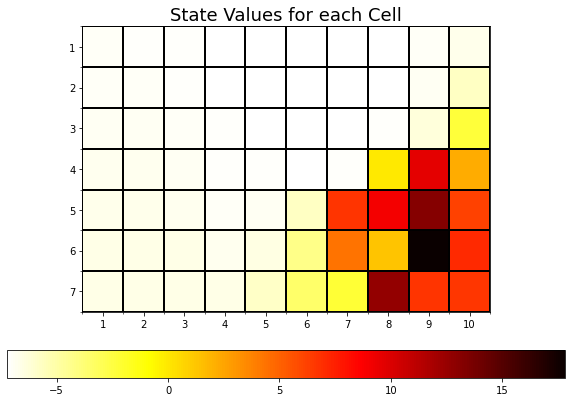



State Values for initial policy:

[[-7.01 -7.04 -7.12 -7.17 -7.21 -7.22 -7.21 -7.16 -7.02 -6.71]
 [-6.96 -7.   -7.07 -7.15 -7.18 -7.2  -7.18 -7.13 -6.9  -5.73]
 [-6.88 -6.92 -7.   -7.12 -7.17 -7.18 -7.16 -7.11 -6.32 -2.26]
 [-6.79 -6.81 -6.9  -7.06 -7.11 -7.13 -7.12  0.    9.7   2.27]
 [-6.69 -6.7  -6.77 -6.95 -6.89 -5.73  6.75  9.07 13.18  6.23]
 [-6.61 -6.61 -6.63 -6.77 -6.48 -4.25  4.34  1.3  17.83  7.1 ]
 [-6.57 -6.56 -6.55 -6.54 -5.77 -3.43 -2.15 12.7   6.76  6.67]] 



In [ ]:
V = policyEvaluation(initPolicy)
print()
plotStateValues(V)
print()
print('\nState Values for initial policy:\n')
print(np.round(V,2),'\n')

# Task 2

Starting from the initial policy, choose actions using ε-greedy action selection (ε=0.1)

Improve the policy by SARSA(λ) for 10,000 episodes.

Compute the resulting state value V(s) for each grid cell.

Visualize the resulting policy using arrows.

## Epsilon Greedy Policy, Non-Deterministic Actions

100%|██████████| 10000/10000 [05:14<00:00, 31.79it/s]


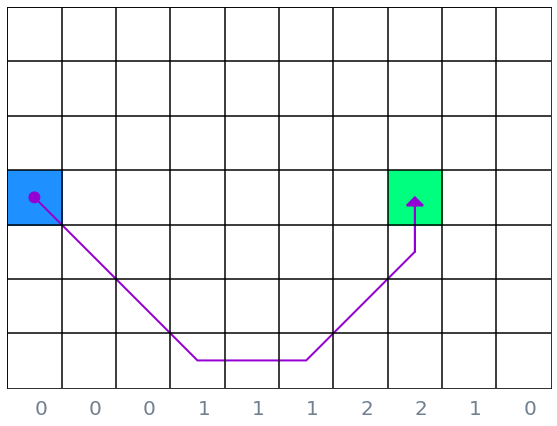

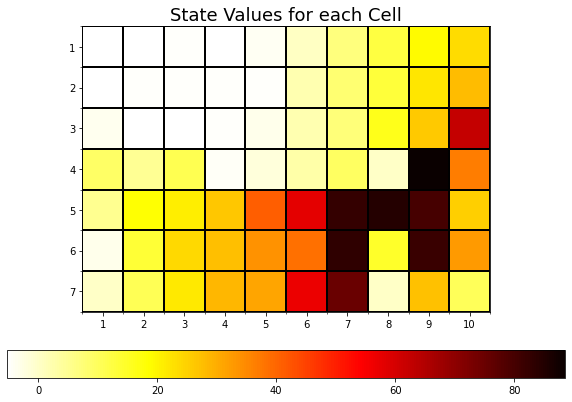


State Values for learned policy:

[[-5.21 -4.96 -4.74 -5.   -3.81  0.47  7.06 12.61 19.21 23.44]
 [-5.09 -4.65 -4.78 -4.62 -4.5   2.35  8.05 13.25 22.11 28.02]
 [-3.38 -4.95 -5.03 -4.62 -3.18  2.15  7.57 16.16 26.24 62.31]
 [ 9.39  4.95 11.27 -4.46 -1.9   3.1   9.76  0.   88.58 36.7 ]
 [ 5.13 18.32 20.99 26.52 41.29 57.93 82.64 84.65 80.04 25.47]
 [-3.22 13.7  23.79 27.72 33.82 38.71 83.09 14.71 81.95 32.73]
 [ 0.28 10.66 21.81 28.52 31.36 57.07 75.06  0.   27.32 10.36]] 



In [ ]:
Q = policyImprovement(deterministic=False)
print()
plotPolicy(Q,deterministic=False)
print()
V = np.max(Q, axis=2)
plotStateValues(V)
print()
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')

## Epsilon Greedy Policy, Non-Deterministic Actions, Replacing Trace

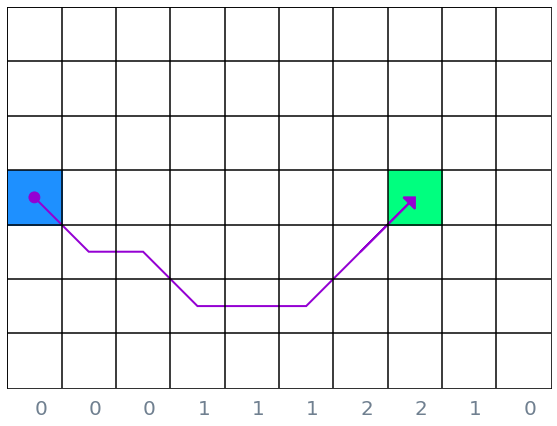

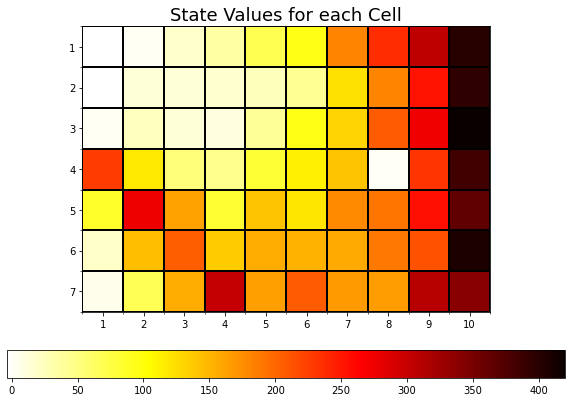


State Values for learned policy:

[[ -3.36   3.21  19.62  36.08  70.74  94.82 180.52 236.9  305.19 401.  ]
 [ -2.96  14.07  13.69  17.04  25.69  42.5  122.95 181.59 254.24 396.71]
 [  3.05  24.68  13.87  11.25  40.56  94.5  132.23 207.29 274.22 420.07]
 [227.46 118.87  53.6   45.48  82.42 113.18 141.1    0.   232.6  384.15]
 [ 86.69 275.4  162.58  83.76 141.87 119.65 178.14 190.86 255.58 365.29]
 [ 21.07 144.5  206.23 137.09 156.19 153.04 157.35 189.28 214.58 408.08]
 [  5.6   68.42 156.38 301.18 164.41 206.83 167.66 166.89 310.19 340.61]] 



In [ ]:
Q = policyImprovement(deterministic=False, replaceTrace=True)
print()
plotPolicy(Q, deterministic=False)
print()
V = np.max(Q, axis=2)
plotStateValues(V)
print()
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')